In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
#train_loader, valid_loader, test_loader = mnist(valid=10000, transform=transforms.ToTensor())

mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
                 lambda x: x.to(device)
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_tanh)

In [5]:
def get_random_h():
    z = torch.randn((50, 64))     
    return z

In [6]:
train_epoch = 1000
batch_size = 50
test_reveal_period = 20
batch_zeros = torch.zeros((batch_size, 1)).to(device)
batch_ones = torch.ones((batch_size, 1)).to(device)

In [7]:
fixed_data, _ = next(iter(test_loader))
fixed_data = fixed_data.to(device)
fixed_h = get_random_h().to(device)

In [8]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.LeakyReLU(0.1), stride=1, device='cpu'):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding, stride=stride))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
        self.to(device)
    
    def forward(self, x):
        return self.model(x)

In [9]:
class DeconvLayer(nn.Module):
    def __init__(self, size, padding=1, stride=1, 
                 bn=False, dropout=False, activation_fn=nn.LeakyReLU(0.1), output_padding=0, device='cpu'):
        super(DeconvLayer, self).__init__()
        layers = []
        layers.append(nn.ConvTranspose2d(size[0], size[1], size[2], padding=padding, 
                                         stride=stride, output_padding=output_padding))
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
        self.to(device)
    
    def forward(self, x):
        return self.model(x)

In [10]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, last_fn=None, device='cpu'):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        self.to(device)
        
    def forward(self, x):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        return self.model(x)

In [11]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, optim_type='SGD', device='cpu', **optim_params):
        super(Net, self).__init__()
        
        self.latent_size = 64
        
        self._conv1 = ConvLayer([1, 32, 4], padding=0, bn=batchnorm, dropout=dropout, stride=2, pool_layer=None, device=device)
        self._conv2 = ConvLayer([32, 64, 4], padding=0, bn=batchnorm, dropout=dropout, stride=2, pool_layer=None, device=device)
        self._conv3 = ConvLayer([64, 64, 3], padding=0, bn=batchnorm, dropout=dropout, stride=2, pool_layer=None, device=device)
        
        self.latent_fn = nn.Sigmoid()
                    
        self.fce = FullyConnected([64*2*2, self.latent_size])
        self.fcd = FullyConnected([self.latent_size, 64*2*2])
        
        self._deconv1 = DeconvLayer([64, 64, 3], stride=2, padding=0, bn=batchnorm, dropout=dropout, device=device)
        self._deconv2 = DeconvLayer([64, 32, 4], stride=2, padding=0, bn=batchnorm, dropout=dropout, output_padding=1, device=device)
        self._deconv3 = DeconvLayer([32, 1, 4], stride=2, padding=0, bn=batchnorm, dropout=dropout, activation_fn=nn.Tanh(), device=device)
    
        if optim_type == 'SGD':
            self.optim = optim.SGD(self.parameters(), **optim_params)
        elif optim_type == 'Adadelta':
            self.optim = optim.Adadelta(self.parameters(), **optim_params)
        elif optim_type == 'RMSProp':
            self.optim = optim.RMSprop(self.parameters(), **optim_params)
        elif optim_type == 'Adam':
            self.optim = optim.Adam(self.parameters(), **optim_params)
                    
        self.discr = FullyConnected([self.latent_size, 512, 512, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), flatten=True, device=device)       
        self.d_optimizer = optim.Adam(self.discr.parameters(), **optim_params)
        
        self.to(device)
       
    def conv(self, x):
        l1 = self._conv1(x)
        l2 = self._conv2(l1)
        l3 = self._conv3(l2)
        return l3, l2, l1
    
    def encode(self, x):
        l3 = self.conv(x)[0]
        flatten = l3.view(-1, 64*2*2)
        h = self.latent_fn(self.fce(flatten))
        return h
    
    def decode(self, h):
        flatten = self.fcd(h)
        l1 = flatten.view(-1, 64, 2, 2)
        l2 = self._deconv1(l1)
        l3 = self._deconv2(l2)
        x = self._deconv3(l3)
        return x
    
    def discriminator(self, x):        
        x = self.discr(x)       
        return x
                
    def forward(self, x):
        self.h = self.encode(x)
        x = self.decode(self.h)
        return x
    
    def ae_loss(self, data):
                       
        output = self.forward(data)     
        self._reconst_loss = F.mse_loss(output, data) 
        
        encoded = self.encode(data) 
        fake_pred = self.discriminator(encoded) 
        self._discr_loss = 0.1 * F.binary_cross_entropy_with_logits(fake_pred, batch_ones)        
        
        self._ae_loss = self._reconst_loss + self._discr_loss
                        
        return self._ae_loss
    
    def ds_loss(self, data):
                       
        encoded = self.encode(data)           
        fake_pred = self.discriminator(encoded)
        true_pred = self.discriminator(get_random_h().to(device))

        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones) 
        self._ds_loss = 0.5*(fake_loss + true_loss)
        
        return self._ds_loss

In [12]:
models = {
    'Adam Discr+bn': Net(True, False, optim_type='Adam', lr=1e-4, device=device),
    'Adam Discr+dp': Net(False, True, optim_type='Adam', lr=1e-4, device=device),
    'Adam Discr+bn+dp': Net(True, True, optim_type='Adam', lr=1e-4, device=device),
}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [13]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        for model in models.values():
            
            # train discriminator
            model.optim.zero_grad()
            model.d_optimizer.zero_grad()
                     
            ds_loss = model.ds_loss(data)        
            ds_loss.backward()
            model.d_optimizer.step()
                        
            # train AE
            model.optim.zero_grad()
            model.d_optimizer.zero_grad()
                      
            ae_loss = model.ae_loss(data)            
            ae_loss.backward()
            model.optim.step()
                       
            
        if batch_idx % 500 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: AE:{:.4f} D:{:.4f}'.format(k, m._ae_loss.item(), m._ds_loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: AE:{:.4f} D:{:.4f}'.format(k, m._ae_loss.item(), m._ds_loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._ae_loss, models[k]._ds_loss))
        print(line + losses)

In [14]:
def plot_latent(images, shape):
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))

    plt.show()
    

In [15]:
def test(models, loader, epoch, log=None):
    test_size = len(loader)
    test_rc_loss = {k: 0. for k in models}
    test_ds_loss = {k: 0. for k in models}
    test_discr_loss = {k: 0. for k in models}
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(train_loader):
            output = {k: m.forward(data) for k, m in models.items()}
            for k, m in models.items():                
                m.ae_loss(data)
                test_rc_loss[k] += m._reconst_loss
                test_discr_loss[k] += m._discr_loss
                test_ds_loss[k] += m.ds_loss(data).item() 
    
    for k in models:
        test_rc_loss[k] /= test_size
        test_discr_loss[k] /= test_size 
        test_ds_loss[k] /= test_size 
    report = 'Test losses: \n' + ''.join(['{}: {:.8f} / {:.8f} / {:.8f} \n'.format(k, test_rc_loss[k], 
                                         test_discr_loss[k], test_ds_loss[k]) 
                                         for k in models])
    if log is not None:
        for k in models:
            log[k].append((test_rc_loss[k], test_discr_loss[k], test_ds_loss[k],))
            if epoch % test_reveal_period == 0:
                with torch.no_grad():
                    print ("Model {}:".format(k))
                    ae_data = models[k].forward(fixed_data).cpu().data.numpy()
                    fixed_gen = models[k].decode(fixed_h).cpu().data.numpy()
                    random_gen = models[k].decode(get_random_h().to(device)).cpu().data.numpy()
                    plot_mnist(ae_data, (5, 10))
                    plot_mnist(fixed_gen, (5, 10)) 
                    plot_mnist(random_gen, (5, 10)) 

                    encoded = model.encode(fixed_data[:10])
                    enc_to_lot = encoded.view(-1, 1, 8, 8).clamp(0, 1).cpu().data.numpy()
                    plot_latent(enc_to_lot, (1, 10))
            
    print(report)

Train Epoch: 1 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.2735 D:0.6922 Adam Discr+dp: AE:1.0103 D:0.6792 Adam Discr+bn+dp: AE:1.0579 D:0.6948
Train Epoch: 1 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:0.9275 D:0.0111 Adam Discr+dp: AE:1.1631 D:0.0132 Adam Discr+bn+dp: AE:1.1666 D:0.0132
Train Epoch: 1 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.0624 D:0.0015 Adam Discr+dp: AE:1.2092 D:0.0051 Adam Discr+bn+dp: AE:1.3507 D:0.0015
Test losses: 
Adam Discr+bn: 2.46564484 / 3.01336694 / 0.00626324 
Adam Discr+dp: 1.91144776 / 2.30318832 / 0.02923923 
Adam Discr+bn+dp: 3.52354050 / 2.96305251 / 0.00689676 

Train Epoch: 2 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.0618 D:0.0013 Adam Discr+dp: AE:1.1234 D:0.0379 Adam Discr+bn+dp: AE:1.3338 D:0.0036
Train Epoch: 2 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.0920 D:0.0005 Adam Discr+dp: AE:1.1874 D:0.0119 Adam Discr+bn+dp: AE:1.3944 D:0.0006
Train Epoch: 2 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.1353 D:0.0003 Adam Discr+dp: AE:1.

Train Epoch: 14 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.5692 D:0.0000 Adam Discr+dp: AE:1.7910 D:0.0001 Adam Discr+bn+dp: AE:1.7676 D:0.0000
Test losses: 
Adam Discr+bn: 0.55001611 / 7.31250572 / 0.00000120 
Adam Discr+dp: 1.50008309 / 5.08282042 / 0.00024399 
Adam Discr+bn+dp: 1.66161847 / 5.94459820 / 0.00001845 

Train Epoch: 15 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.5697 D:0.0000 Adam Discr+dp: AE:1.8494 D:0.0001 Adam Discr+bn+dp: AE:1.8493 D:0.0001
Train Epoch: 15 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.5509 D:0.0000 Adam Discr+dp: AE:1.7036 D:0.0000 Adam Discr+bn+dp: AE:1.8446 D:0.0000
Train Epoch: 15 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.3043 D:0.0000 Adam Discr+dp: AE:1.7273 D:0.0000 Adam Discr+bn+dp: AE:1.8290 D:0.0000
Test losses: 
Adam Discr+bn: 0.87069964 / 5.71531677 / 0.00018759 
Adam Discr+dp: 1.50770807 / 5.41852951 / 0.00007535 
Adam Discr+bn+dp: 1.65100908 / 5.63712978 / 0.00005530 

Train Epoch: 16 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1

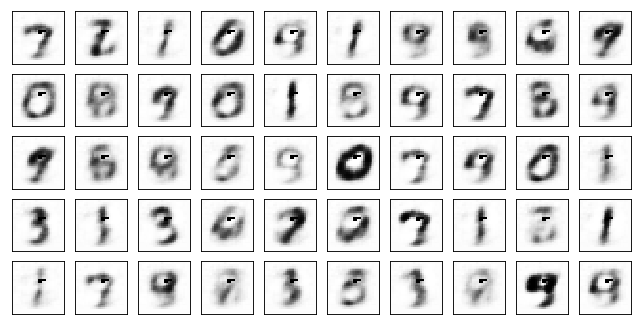

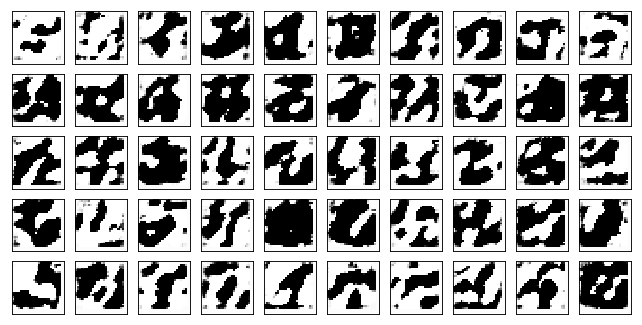

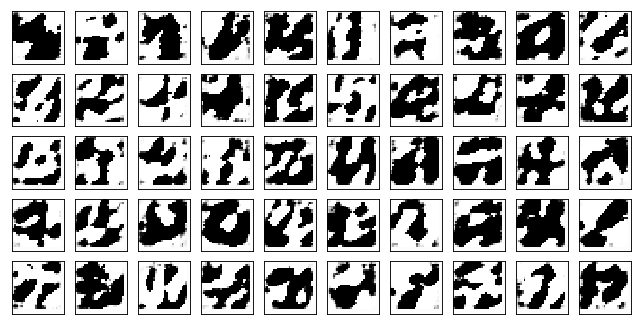

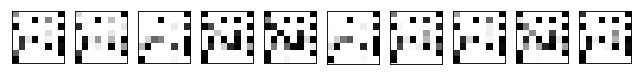

Model Adam Discr+dp:


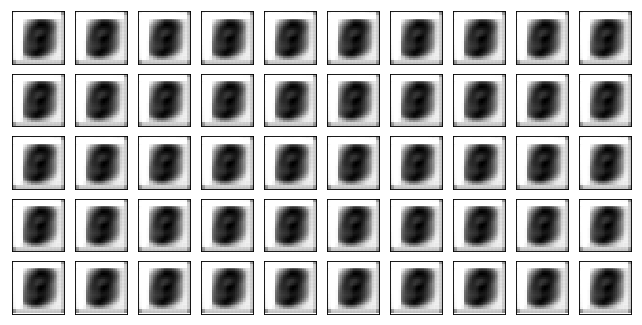

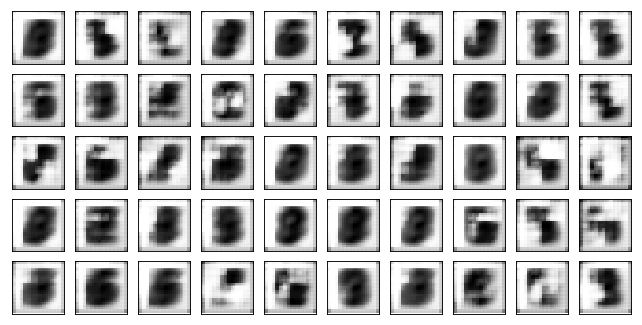

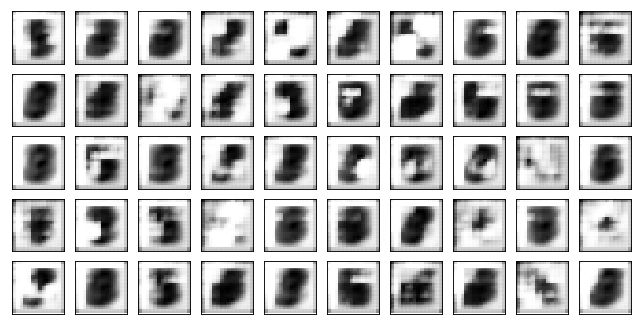

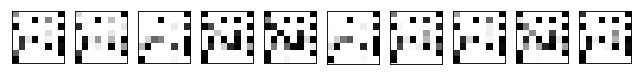

Model Adam Discr+bn+dp:


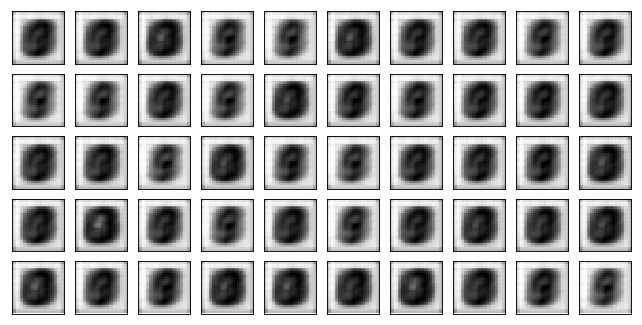

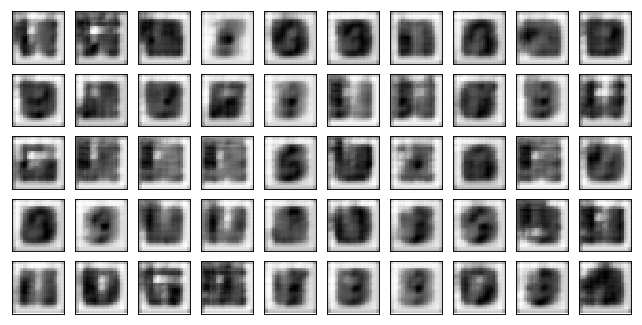

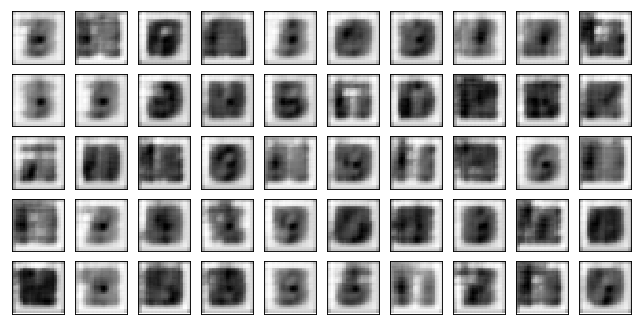

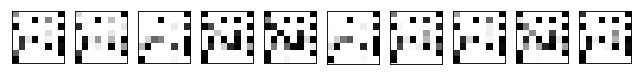

Test losses: 
Adam Discr+bn: 0.87053227 / 7.13411522 / 0.00000212 
Adam Discr+dp: 1.48493981 / 7.26975346 / 0.00001013 
Adam Discr+bn+dp: 1.58889782 / 6.51963854 / 0.00009498 

Train Epoch: 26 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.5944 D:0.0000 Adam Discr+dp: AE:1.8950 D:0.0000 Adam Discr+bn+dp: AE:2.0904 D:0.0000
Train Epoch: 26 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.5933 D:0.0000 Adam Discr+dp: AE:1.8663 D:0.0000 Adam Discr+bn+dp: AE:1.7728 D:0.0000
Train Epoch: 26 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.6769 D:0.0000 Adam Discr+dp: AE:1.8685 D:0.0000 Adam Discr+bn+dp: AE:1.8468 D:0.0000
Test losses: 
Adam Discr+bn: 0.86991864 / 7.41408539 / 0.00000129 
Adam Discr+dp: 1.49787569 / 6.36063099 / 0.00007669 
Adam Discr+bn+dp: 1.55024135 / 6.51018476 / 0.00000566 

Train Epoch: 27 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.7108 D:0.0000 Adam Discr+dp: AE:1.8972 D:0.0000 Adam Discr+bn+dp: AE:1.9296 D:0.0000
Train Epoch: 27 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.

Train Epoch: 39 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.5337 D:0.0000 Adam Discr+dp: AE:1.6686 D:0.0306 Adam Discr+bn+dp: AE:1.9456 D:0.0000
Train Epoch: 39 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.5138 D:0.0001 Adam Discr+dp: AE:1.8665 D:0.0000 Adam Discr+bn+dp: AE:2.1396 D:0.0000
Test losses: 
Adam Discr+bn: 1.34438992 / 6.05811834 / 0.00001865 
Adam Discr+dp: 1.47389066 / 6.83349037 / 0.00002585 
Adam Discr+bn+dp: 1.49626005 / 7.48902655 / 0.00000111 

Train Epoch: 40 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.4395 D:0.0000 Adam Discr+dp: AE:1.8305 D:0.0001 Adam Discr+bn+dp: AE:2.0836 D:0.0000
Train Epoch: 40 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.5258 D:0.0000 Adam Discr+dp: AE:1.8763 D:0.0000 Adam Discr+bn+dp: AE:2.0525 D:0.0000
Train Epoch: 40 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.5783 D:0.0000 Adam Discr+dp: AE:1.7992 D:0.0001 Adam Discr+bn+dp: AE:2.1476 D:0.0000
Test losses: 
Adam Discr+bn: 1.24867249 / 6.68230247 / 0.00004441 
Adam Discr+dp: 1.48

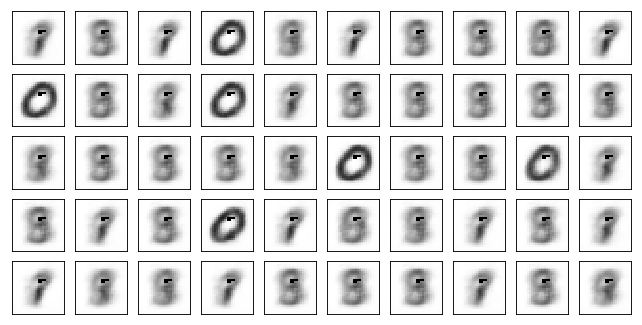

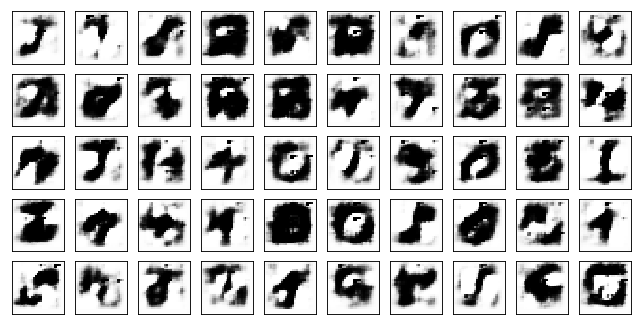

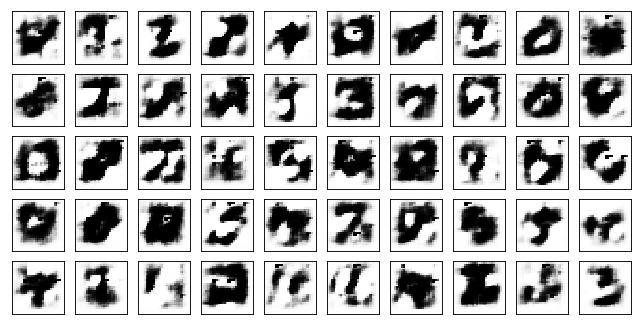

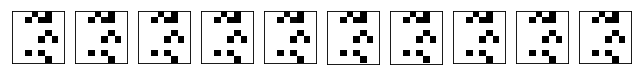

Model Adam Discr+dp:


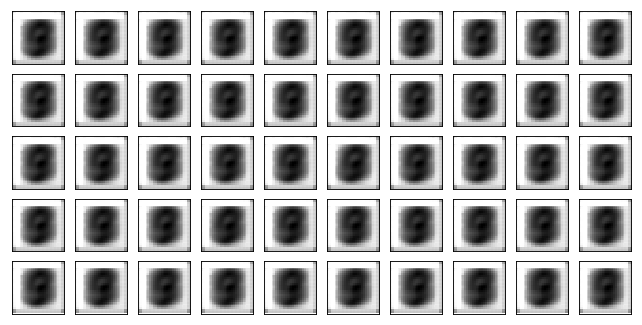

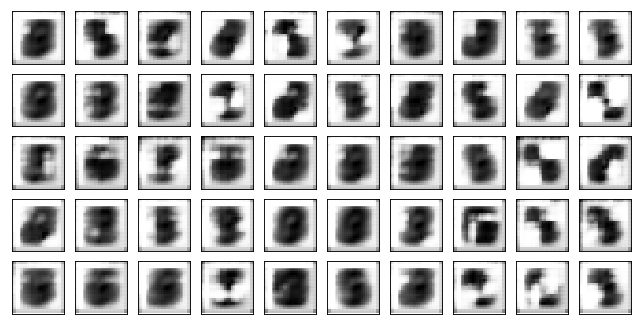

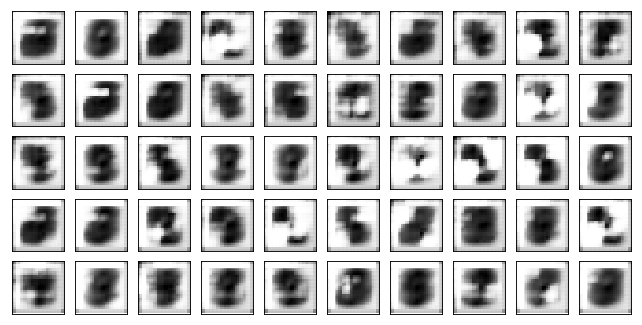

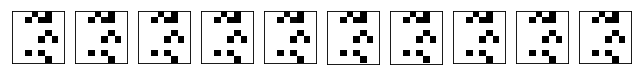

Model Adam Discr+bn+dp:


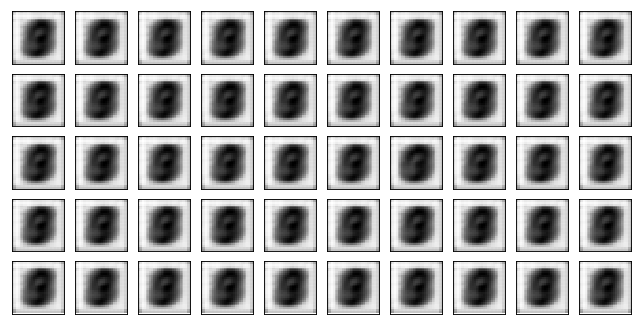

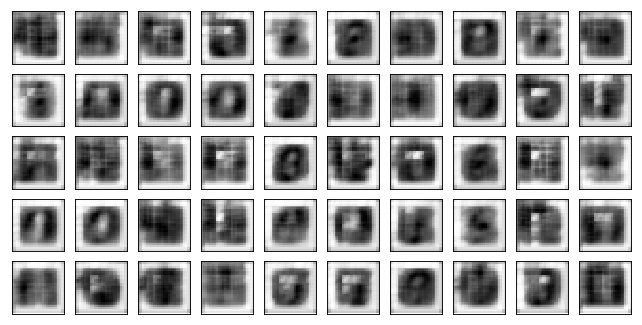

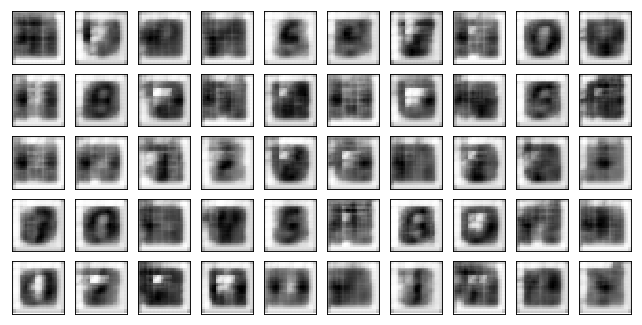

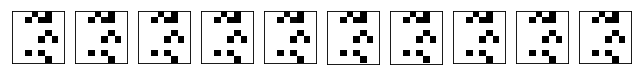

Test losses: 
Adam Discr+bn: 1.23897290 / 6.70258284 / 0.00000445 
Adam Discr+dp: 1.48677909 / 6.50883579 / 0.00000827 
Adam Discr+bn+dp: 1.51081514 / 7.20084190 / 0.00000152 

Train Epoch: 51 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.5899 D:0.0000 Adam Discr+dp: AE:1.9439 D:0.0000 Adam Discr+bn+dp: AE:2.0142 D:0.0000
Train Epoch: 51 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.7178 D:0.0000 Adam Discr+dp: AE:1.9094 D:0.0000 Adam Discr+bn+dp: AE:2.1832 D:0.0000
Train Epoch: 51 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.6565 D:0.0000 Adam Discr+dp: AE:1.9105 D:0.0000 Adam Discr+bn+dp: AE:2.2867 D:0.0000
Test losses: 
Adam Discr+bn: 1.15964854 / 7.50921202 / 0.00000140 
Adam Discr+dp: 1.49875665 / 6.94324207 / 0.00015384 
Adam Discr+bn+dp: 1.51056457 / 7.84775496 / 0.00000064 

Train Epoch: 52 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.6602 D:0.0000 Adam Discr+dp: AE:1.9109 D:0.0000 Adam Discr+bn+dp: AE:2.2106 D:0.0000
Train Epoch: 52 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.

Train Epoch: 64 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.6507 D:0.0000 Adam Discr+dp: AE:1.9181 D:0.0000 Adam Discr+bn+dp: AE:1.9793 D:0.0000
Train Epoch: 64 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.8273 D:0.0000 Adam Discr+dp: AE:1.7704 D:0.0000 Adam Discr+bn+dp: AE:1.9521 D:0.0000
Test losses: 
Adam Discr+bn: 1.05928767 / 8.09998703 / 0.00000038 
Adam Discr+dp: 1.48481882 / 6.43581820 / 0.00001178 
Adam Discr+bn+dp: 1.47263134 / 7.07373285 / 0.00000200 

Train Epoch: 65 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.8151 D:0.0000 Adam Discr+dp: AE:1.9086 D:0.0001 Adam Discr+bn+dp: AE:1.9470 D:0.0000
Train Epoch: 65 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.5350 D:0.0000 Adam Discr+dp: AE:1.8573 D:0.0000 Adam Discr+bn+dp: AE:2.0020 D:0.0000
Train Epoch: 65 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.6689 D:0.0000 Adam Discr+dp: AE:1.8566 D:0.0000 Adam Discr+bn+dp: AE:2.2129 D:0.0000
Test losses: 
Adam Discr+bn: 0.95889825 / 7.79233646 / 0.00000040 
Adam Discr+dp: 1.49

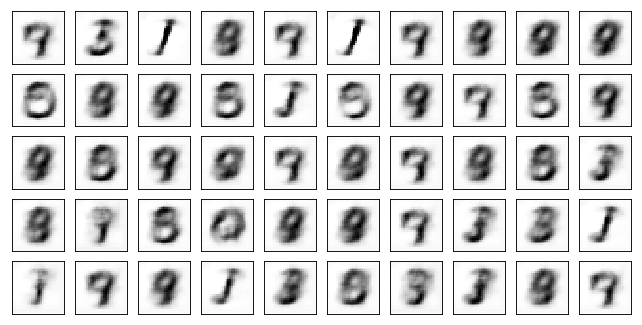

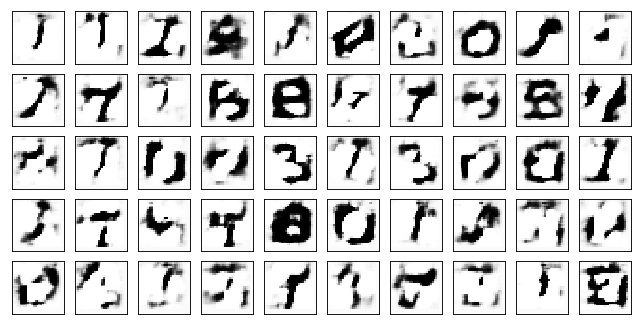

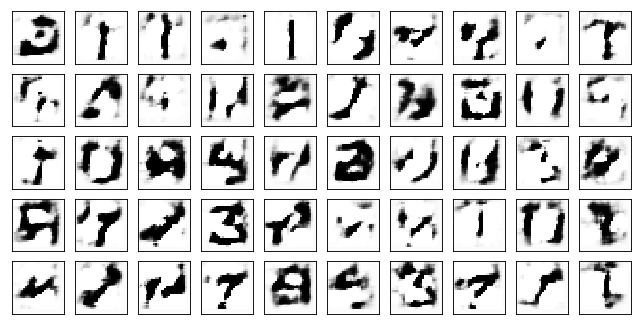

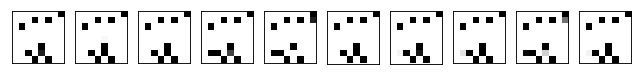

Model Adam Discr+dp:


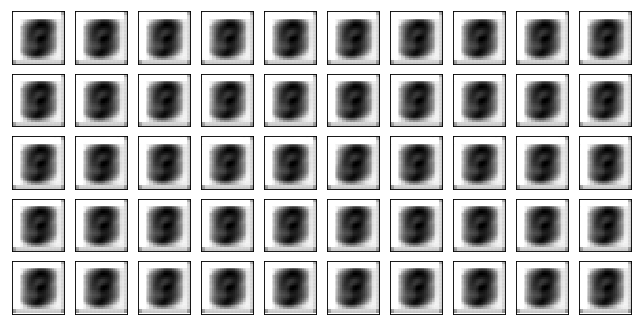

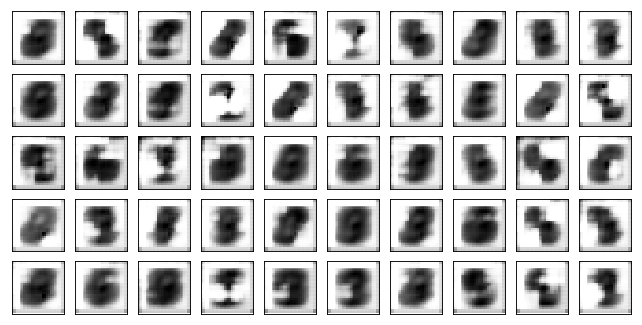

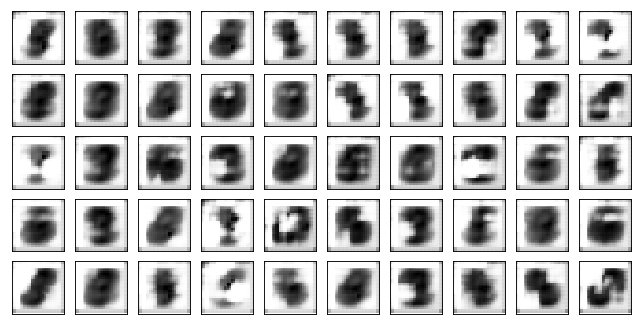

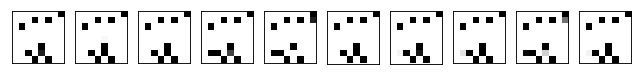

Model Adam Discr+bn+dp:


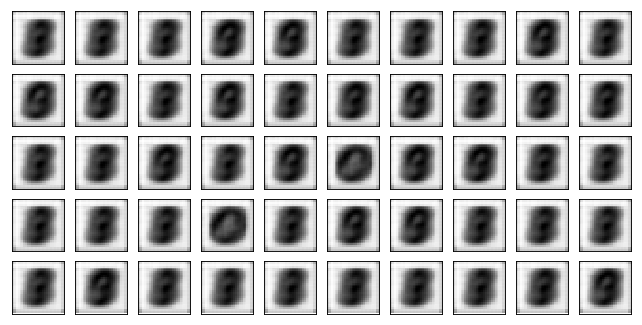

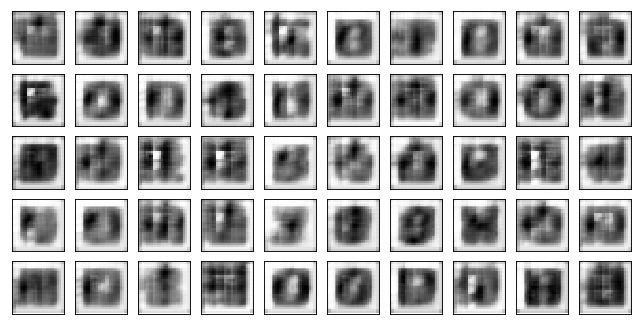

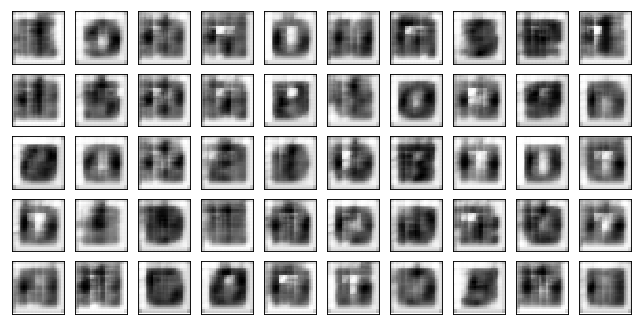

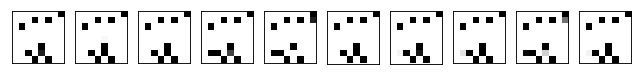

Test losses: 
Adam Discr+bn: 1.14172792 / 6.52468538 / 0.00004058 
Adam Discr+dp: 1.47567093 / 7.34719849 / 0.00000135 
Adam Discr+bn+dp: 1.45995486 / 7.27217102 / 0.00000156 

Train Epoch: 76 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.4973 D:0.0000 Adam Discr+dp: AE:1.9508 D:0.0000 Adam Discr+bn+dp: AE:2.0919 D:0.0000
Train Epoch: 76 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.5651 D:0.0000 Adam Discr+dp: AE:1.7191 D:0.0001 Adam Discr+bn+dp: AE:2.0456 D:0.0000
Train Epoch: 76 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.5375 D:0.0000 Adam Discr+dp: AE:1.7862 D:0.0000 Adam Discr+bn+dp: AE:1.9319 D:0.0000
Test losses: 
Adam Discr+bn: 1.04457510 / 6.71948004 / 0.00000392 
Adam Discr+dp: 1.47584915 / 6.88531780 / 0.00000295 
Adam Discr+bn+dp: 1.46108603 / 6.70534945 / 0.00000425 

Train Epoch: 77 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.5275 D:0.0000 Adam Discr+dp: AE:1.9387 D:0.0000 Adam Discr+bn+dp: AE:1.9607 D:0.0000
Train Epoch: 77 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.

Train Epoch: 89 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.6346 D:0.0000 Adam Discr+dp: AE:1.7810 D:0.0000 Adam Discr+bn+dp: AE:2.1450 D:0.0000
Train Epoch: 89 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.6677 D:0.0000 Adam Discr+dp: AE:1.7921 D:0.0000 Adam Discr+bn+dp: AE:2.0996 D:0.0000
Test losses: 
Adam Discr+bn: 1.09172356 / 7.36091280 / 0.00000316 
Adam Discr+dp: 1.49016511 / 6.36592388 / 0.00001587 
Adam Discr+bn+dp: 1.49227643 / 7.68375826 / 0.00000167 

Train Epoch: 90 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.6878 D:0.0000 Adam Discr+dp: AE:1.9195 D:0.0000 Adam Discr+bn+dp: AE:2.1695 D:0.0000
Train Epoch: 90 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.6336 D:0.0000 Adam Discr+dp: AE:1.8756 D:0.0000 Adam Discr+bn+dp: AE:2.2656 D:0.0000
Train Epoch: 90 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.5367 D:0.0000 Adam Discr+dp: AE:1.8600 D:0.0000 Adam Discr+bn+dp: AE:1.9956 D:0.0000
Test losses: 
Adam Discr+bn: 1.23472214 / 6.53317308 / 0.00001608 
Adam Discr+dp: 1.47

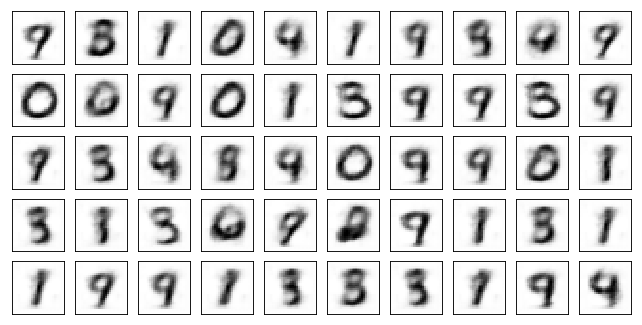

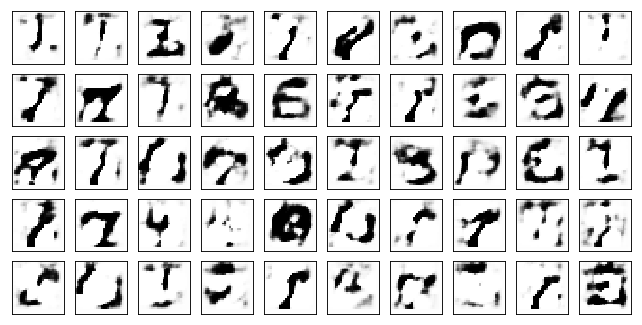

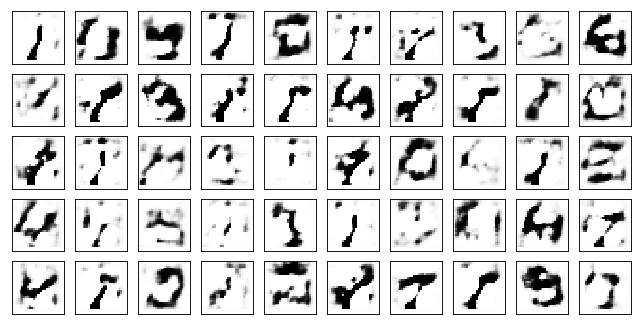

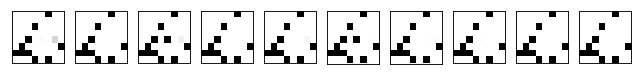

Model Adam Discr+dp:


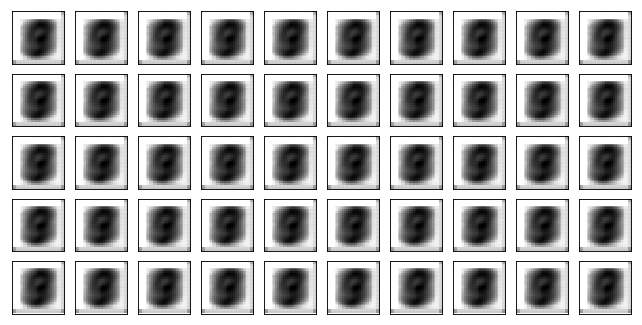

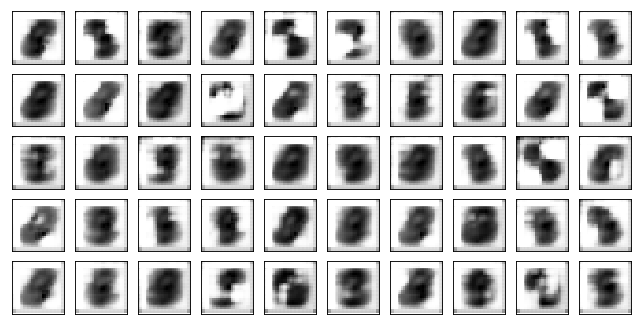

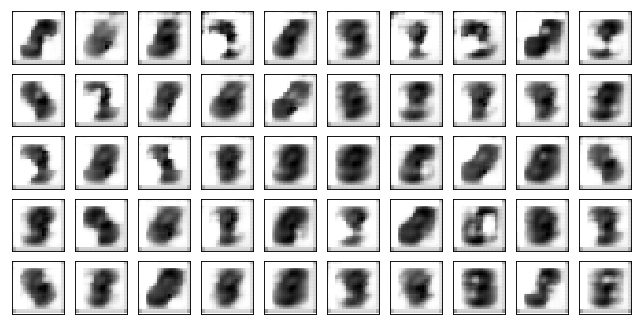

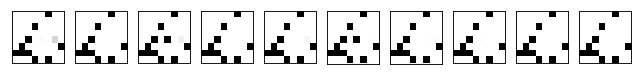

Model Adam Discr+bn+dp:


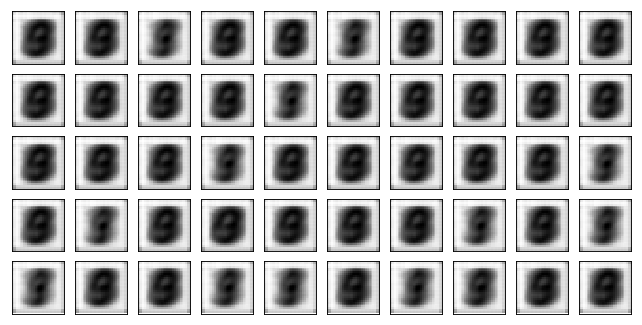

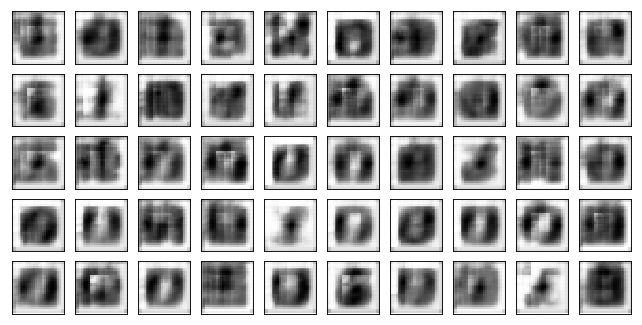

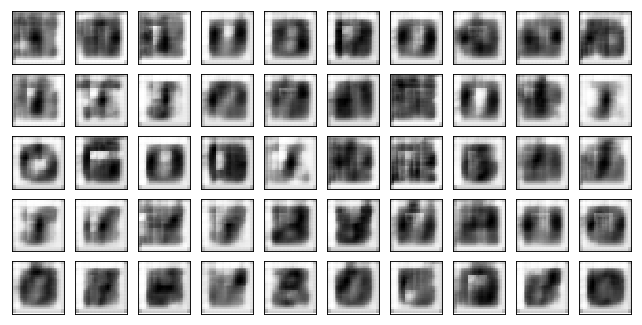

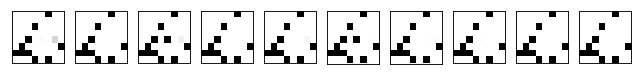

Test losses: 
Adam Discr+bn: 0.94527626 / 7.95031357 / 0.00000031 
Adam Discr+dp: 1.47953093 / 7.25210810 / 0.00000140 
Adam Discr+bn+dp: 1.47256541 / 7.86979437 / 0.00000030 

Train Epoch: 101 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.7343 D:0.0000 Adam Discr+dp: AE:2.0089 D:0.0000 Adam Discr+bn+dp: AE:2.0725 D:0.0000
Train Epoch: 101 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.6708 D:0.0000 Adam Discr+dp: AE:1.7957 D:0.0000 Adam Discr+bn+dp: AE:2.1566 D:0.0000
Train Epoch: 101 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.4194 D:0.0000 Adam Discr+dp: AE:1.7940 D:0.0000 Adam Discr+bn+dp: AE:2.0335 D:0.0000
Test losses: 
Adam Discr+bn: 1.01840484 / 6.06715584 / 0.00001589 
Adam Discr+dp: 1.45392513 / 6.94579935 / 0.00000687 
Adam Discr+bn+dp: 1.46871698 / 7.32502079 / 0.00000119 

Train Epoch: 102 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.3592 D:0.0000 Adam Discr+dp: AE:1.9193 D:0.0000 Adam Discr+bn+dp: AE:1.9773 D:0.0000
Train Epoch: 102 [25000/50000 (50%)]	Losses Adam Discr+bn: 

Train Epoch: 114 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.5575 D:0.0000 Adam Discr+dp: AE:1.9706 D:0.0000 Adam Discr+bn+dp: AE:2.1342 D:0.0000
Train Epoch: 114 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.6750 D:0.0000 Adam Discr+dp: AE:1.9940 D:0.0000 Adam Discr+bn+dp: AE:2.0892 D:0.0000
Test losses: 
Adam Discr+bn: 0.87744832 / 7.35113144 / 0.00000114 
Adam Discr+dp: 1.47370470 / 6.73308039 / 0.00002320 
Adam Discr+bn+dp: 1.45692003 / 7.69141531 / 0.00000059 

Train Epoch: 115 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.6364 D:0.0000 Adam Discr+dp: AE:1.9697 D:0.0000 Adam Discr+bn+dp: AE:2.0655 D:0.0000
Train Epoch: 115 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.6590 D:0.0000 Adam Discr+dp: AE:1.8205 D:0.0000 Adam Discr+bn+dp: AE:2.0628 D:0.0000
Train Epoch: 115 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.5124 D:0.0000 Adam Discr+dp: AE:1.8027 D:0.0000 Adam Discr+bn+dp: AE:2.0687 D:0.0000
Test losses: 
Adam Discr+bn: 0.95198250 / 6.73022318 / 0.00000388 
Adam Discr+dp:

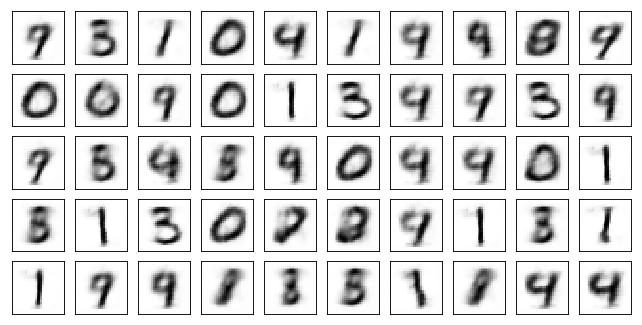

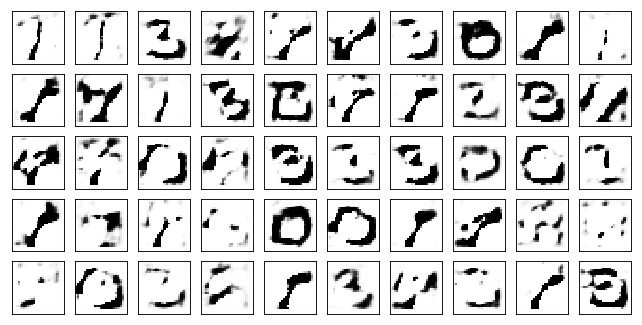

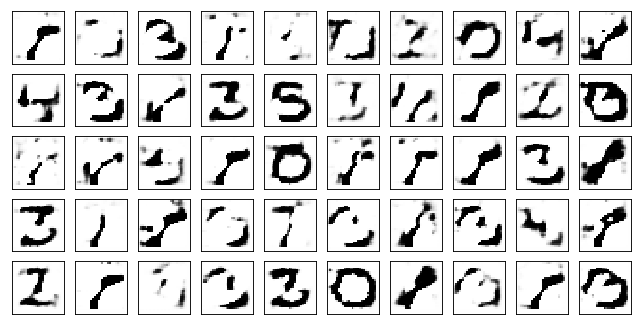

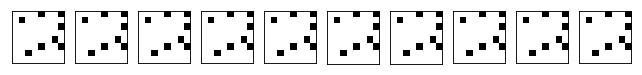

Model Adam Discr+dp:


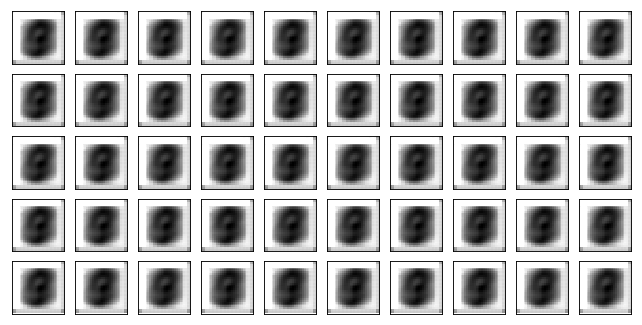

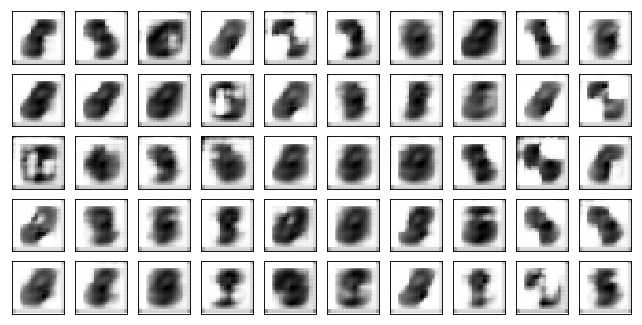

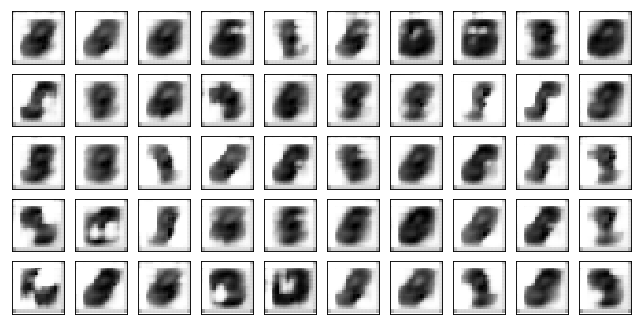

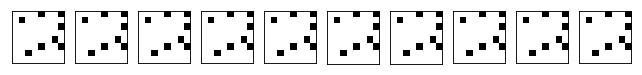

Model Adam Discr+bn+dp:


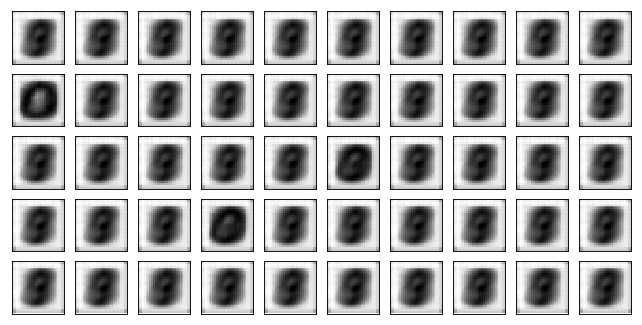

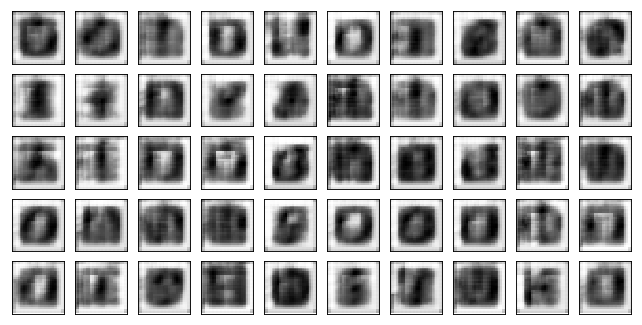

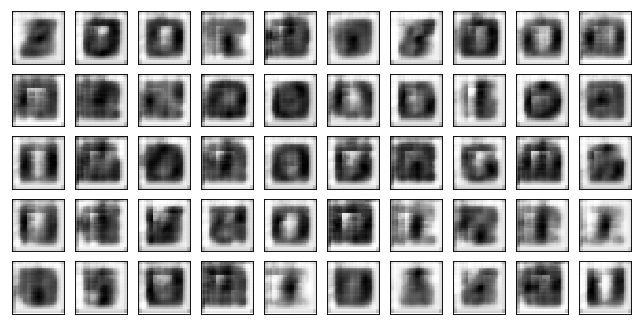

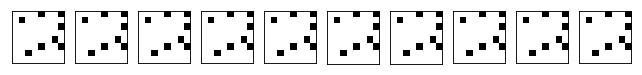

Test losses: 
Adam Discr+bn: 0.92611867 / 7.73441696 / 0.00000255 
Adam Discr+dp: 1.47695816 / 7.26132250 / 0.00000396 
Adam Discr+bn+dp: 1.46734178 / 7.24241495 / 0.00000142 

Train Epoch: 126 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.6716 D:0.0000 Adam Discr+dp: AE:2.0143 D:0.0000 Adam Discr+bn+dp: AE:1.9907 D:0.0000
Train Epoch: 126 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.5814 D:0.0000 Adam Discr+dp: AE:1.9485 D:0.0000 Adam Discr+bn+dp: AE:2.0220 D:0.0000


KeyboardInterrupt: 

In [16]:
test_reveal_period = 25
for epoch in range(1, train_epoch):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, epoch, test_log)

In [ ]:
test_reveal_period = 1
for model in models.values():
    model.eval()
test(models, valid_loader, test_log)

In [ ]:
torch.save(models['Adam Discr+bn'], './adam_ds_bn_l64_1')
torch.save(models['Adam Discr+dp'], './adam_ds_dp_l64_1')
torch.save(models['Adam Discr+bn+dp'], './adam_ds_bndp_l64_1')

### Вывод результатов

In [ ]:
model = torch.load('./adam_ds_bndp_l64_1')

In [ ]:
data, _ = next(iter(test_loader))
output = model(data)
to_plot = output.view(-1, 1, 28, 28).clamp(-1, 1).data.numpy()
with torch.no_grad():
    encoded = model.encode(data)
    enc_to_lot = encoded.view(-1, 1, 8, 8).clamp(-1, 1).data.numpy()
    print ('enc=', encoded.shape)


In [ ]:
plot_mnist(data.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_latent(enc_to_lot, (5, 10))

In [ ]:
def show_generated_samples():
    pred_z = torch.randn((50, 16))
       
    pred_gen = model.decode(pred_z)
    generated = pred_gen.view(-1, 1, 28, 28).data.numpy()  
    plot_mnist(generated, (5, 10))

In [ ]:
show_generated_samples()